First we will import in all the libraries and data that we need.  

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score


reposperlang = pd.read_csv("ReposPerLang.csv")
langpairs = pd.read_csv("LangPairsPerRepoTop1000.csv")

**A.** Now we are going to have to calculate the empirical cumulative distribution function (CDF), the complement of the empirical cumulative distribution function (CCDF), and the percent of total repositories are in each language (Perc).  First we will create new columns for each of these and initialize them to 0.  Then we will run a for-loop to calculate each of them for each language.  

In [2]:
#Initialize new columns to 0
reposperlang['CDF'] = 0
reposperlang['CCDF'] = 0
reposperlang['Perc'] = 0

#Calculates empirical CDF, empirical CCDF, and Perc
for i in range(0,reposperlang.shape[0]):
    reposperlang.loc[i,'CDF'] = reposperlang.loc[i:, 'cnt'].shape[0] / reposperlang.loc[:, 'cnt'].shape[0]
    reposperlang.loc[i,'CCDF'] = 1 - (reposperlang.loc[i:, 'cnt'].shape[0] / reposperlang.loc[:, 'cnt'].shape[0])
    reposperlang.loc[i,'Perc'] = reposperlang.loc[i, 'cnt'] / reposperlang.loc[:, 'cnt'].sum()

**A.** *1.* Now we will plot the empirical CDF of the Repositories per language.  It goes up very quickly since most languages have lower counts, and then sort of levels off.  

Text(0.5,1,'Empirical CDF of Repositories per Language in GitHub')

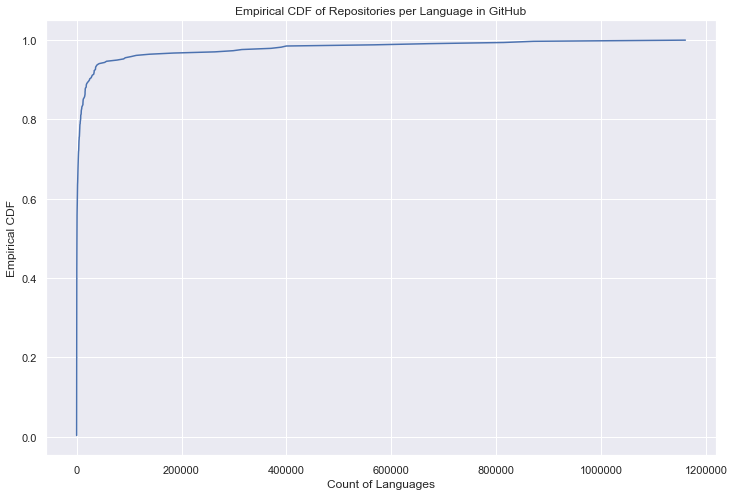

In [3]:
#Plots the empirical CDF of the number of repositories using a language
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(reposperlang['cnt'],reposperlang['CDF'])
plt.xlabel('Count of Languages')
plt.ylabel('Empirical CDF')
plt.title('Empirical CDF of Repositories per Language in GitHub')

**A.** *2.* Now we will plot the complement of the empirical CDF, but with the x-axis on a log scale.  This seems to more closely mirror a Gaussian distribution with the steepest slope around y = 0.5, and leveling off close to y = 0 and y = 1.  

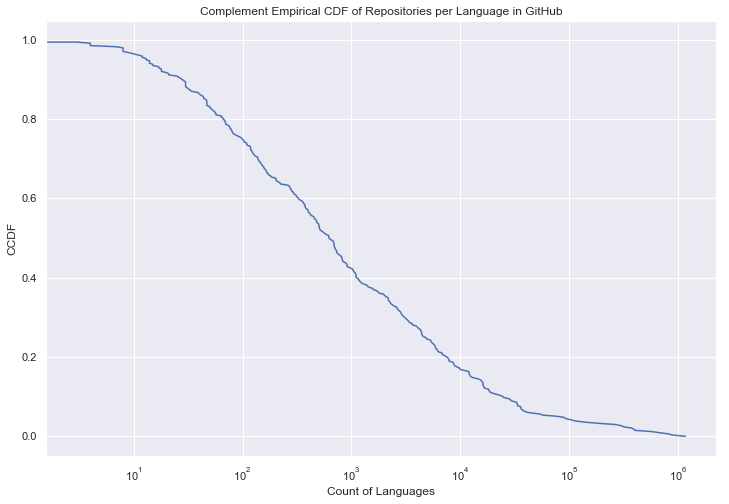

In [4]:
#Plots the empirical CDF of the number of repositories using a language
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(reposperlang['cnt'],reposperlang['CCDF'])
plt.xlabel('Count of Languages')
plt.ylabel('CCDF')
plt.title('Complement Empirical CDF of Repositories per Language in GitHub')
plt.xscale('log')

**A.** *3.* Next we will make a stem-plot of the Number of Repositories per language in decreasing order.  At the start, it is very high, and then quickly decreases and levels off.  There are a lot of languages that are only used a little, but a few that are really popular.  

Text(0.5,1,'Stemplot of Number of Repositories Per Language')

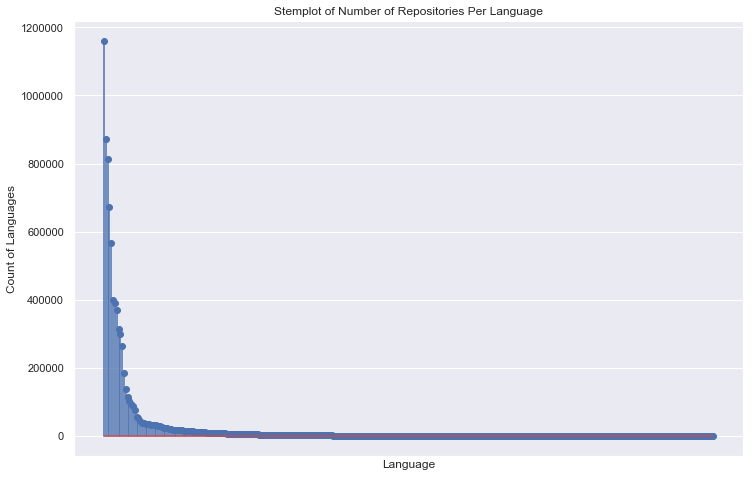

In [5]:
#Stemplot of Number of repositories per language
plt.rcParams["figure.figsize"] = [12,8]
plt.stem(reposperlang['cnt'])
plt.xticks([])
plt.xlabel('Language')
plt.ylabel('Count of Languages')
plt.title('Stemplot of Number of Repositories Per Language')

**A.** *4.* For the last part of A, we will make a horizontal bar plot of the top 30 most popular languages in decreasing order where the x-axis is the percent of languages used in respositories that are this language.  

Text(0.5,1,'GitHub Language Popularity')

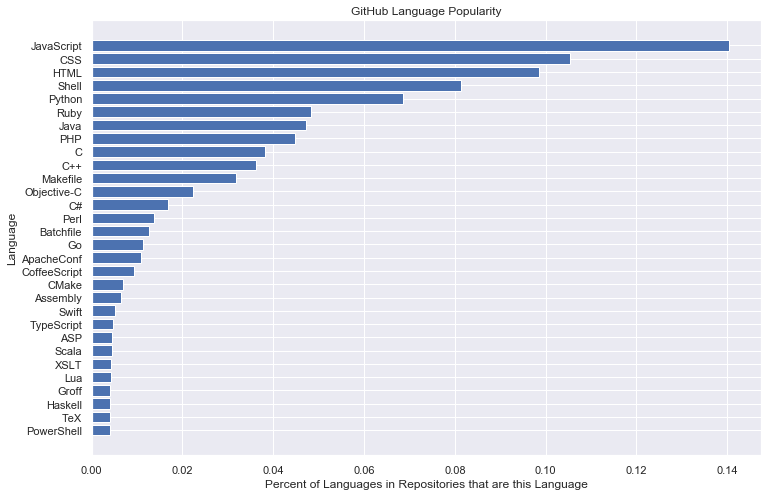

In [6]:
#Horizontal barplot of language popularity by percent of total langauges
plt.rcParams["figure.figsize"] = [12,8]
plt.barh(reposperlang.loc[0:29,'lang'], reposperlang.loc[0:29,'Perc'])
plt.gca().invert_yaxis()
plt.xlabel('Percent of Languages in Repositories that are this Language')
plt.ylabel('Language')
plt.title('GitHub Language Popularity')

**B.** First, we will also assume that if a pair of languages is not in lang-pairs-per-repo-top-1000.csv, then it has a value of 0.  This is not accurate since we only have information for the top 1000 pairs, but there is little else that we can do to fill in the other information.  Now, we need to create two matrices, first initialized to 0 since these will be there values if there are no shared repositories that we know of.  Since there are 337 unique languages (the last entry in the reposperlang.csv is NaN and has a value of 0), then each matrix will be 337x337 where each row and each column represent a unique language.  In the first matrix, each cell will be the count of how many repositories overlap between the two languages.  Note: along the diagonal, the two languages are the same so we will use the total number of repositories in that language.  In the second matrix, we will calculate the cosine similarity which should be the total number of shared languages over product of the square roots of their individual numbers.  i.e. If language A appears 25 times, and language B appears 36 times, and they appear together 10 times then their cosine similarity should be $\frac{10}{\sqrt{25}\sqrt{36}} = \frac{1}{3}$.  Note: if A and B are the same language, their cosine similarity would be 1, and if there is no overlap that we know about, their cosine similarity would be 0.  

In [7]:
#Creates a matrix of 0's to store the values of shared repositories for every pair of languages
fullVals = pd.DataFrame(index=reposperlang.loc[0:(reposperlang.shape[0]-2),'lang'], columns=reposperlang.loc[0:(reposperlang.shape[0]-2),'lang'])
fullVals = fullVals.fillna(0)

#Creates a matrix of 0's to store the cosine similarity for every pair of languages
CosSim = pd.DataFrame(index=reposperlang.loc[0:(reposperlang.shape[0]-2),'lang'], columns=reposperlang.loc[0:(reposperlang.shape[0]-2),'lang'])
CosSim = CosSim.fillna(0)


#Here we use the forloop to fill in the values of the two matrices above
for i in range(0,(reposperlang.shape[0]-1)):
    ilang = reposperlang.loc[i,'lang']
    temp = langpairs[(langpairs['lgn']==ilang) | (langpairs['t2_lgn'] == ilang)]
    
    for j in range(0,(reposperlang.shape[0]-1)):
        jlang = reposperlang.loc[j,'lang']
        
        if i == j:
            fullVals.iloc[i,j] = reposperlang.loc[i,'cnt']
            CosSim.iloc[i,j] = 1
        
        elif j != 9:
            if any(temp['lgn']==jlang) | any(temp['t2_lgn'] == jlang):
                newtemp = temp[(temp['lgn']==jlang) | (temp['t2_lgn'] == jlang)]
                fullVals.iloc[i,j] = newtemp.iloc[0]['cnt']
                fullVals.iloc[j,i] = newtemp.iloc[0]['cnt']
                
                CosSim.iloc[i,j] = newtemp.iloc[0]['cnt'] / (math.sqrt(reposperlang.loc[i,'cnt']) * math.sqrt(reposperlang.loc[j,'cnt']))
                CosSim.iloc[j,i] = newtemp.iloc[0]['cnt'] / (math.sqrt(reposperlang.loc[i,'cnt']) * math.sqrt(reposperlang.loc[j,'cnt']))
             

**B.** *1.* Now we will plot heatmaps of their co-usage counts using a log-scale in 3 different orders.  First, we will create a new matrix to replace the 0 values with 0.1 so we can use a log scale and then we will set up the other variables necessary for the log scale.  

In [8]:
#Replaces 0 with 0.1 for log-scale to work
NoZeroes = fullVals.replace(0,0.1)

#Creates variables to use log-scale in heatmat
log_norm = LogNorm(vmin=NoZeroes.min().min(), vmax=NoZeroes.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(NoZeroes.min().min())+1), 1+math.ceil(math.log10(NoZeroes.max().max())))]

**B.** *1.* Now we plot a heatmap of their co-usage counts using a log-scale.  First, we will order by random permutation.  

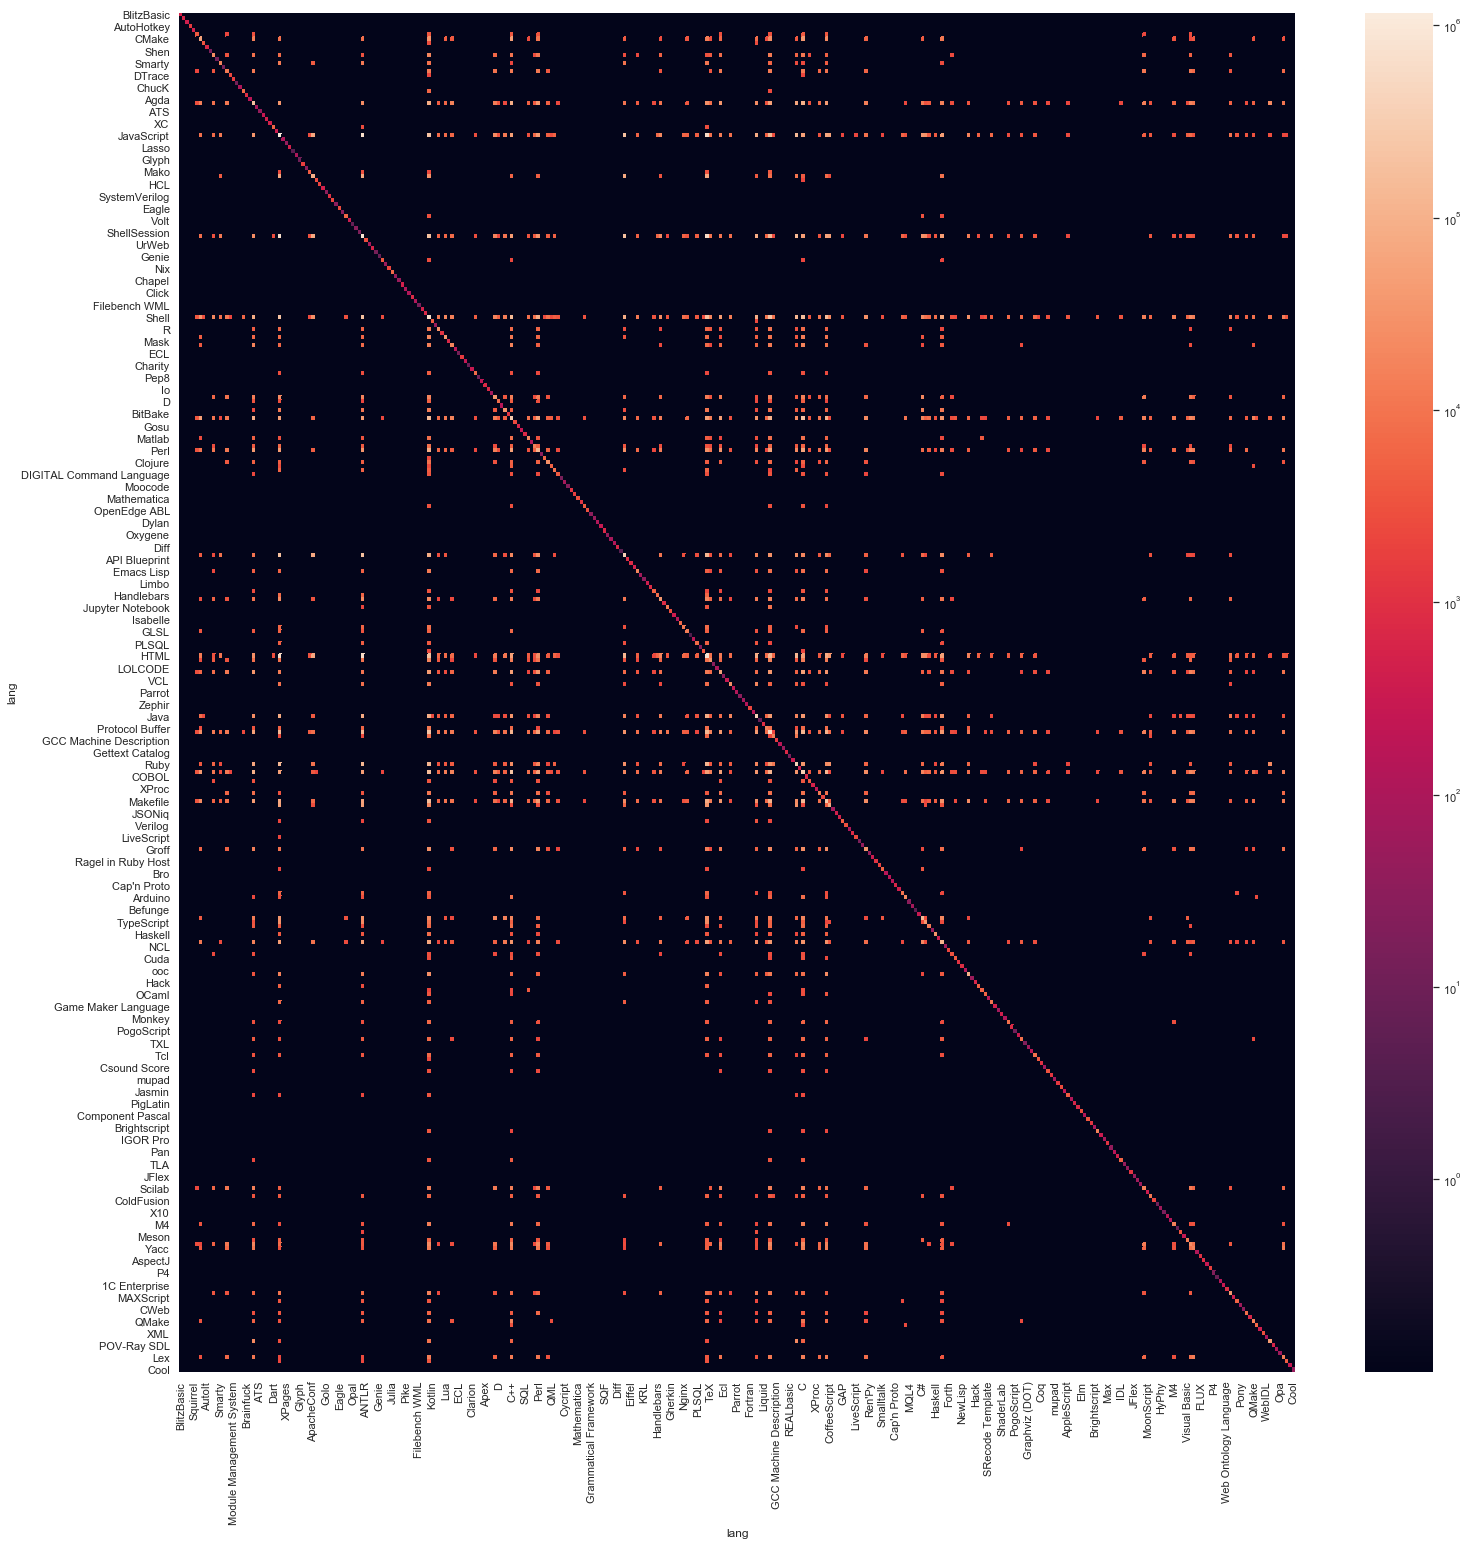

In [9]:
#Creates the random permutation, and then orders the matrix by that
rndperm = np.random.permutation(NoZeroes.shape[0])
Aperm = NoZeroes.iloc[rndperm,:] 
Aperm = Aperm.iloc[:,rndperm]

#Creates the heatmap for counts in random permutation order and log-scale
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(Aperm, norm=log_norm, cbar_kws={"ticks": cbar_ticks})


**B.** *1.* Next we will order by decreasing order of programming language popularity.  

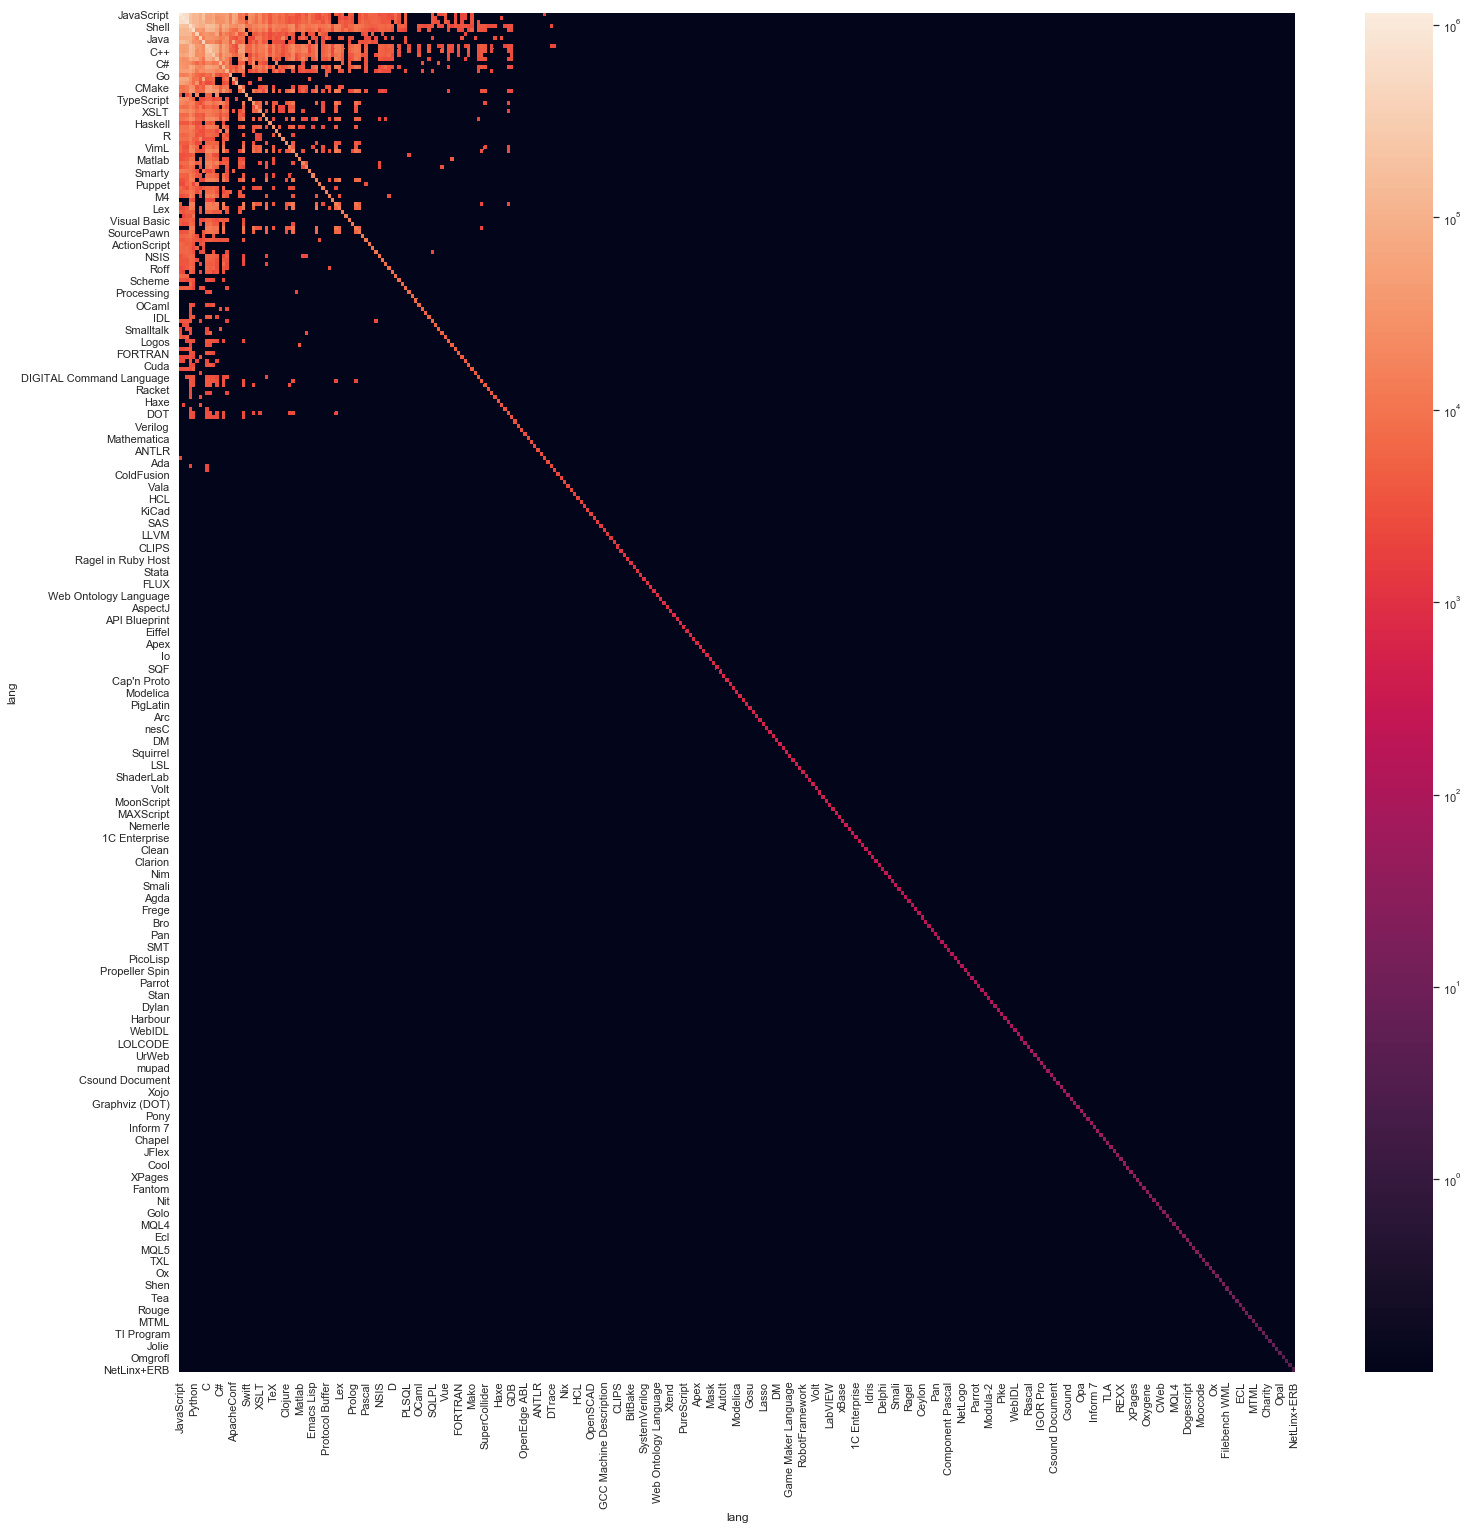

In [10]:
#Creates the heatmap for counts in decreasing popularity order and log-scale
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(NoZeroes, norm=log_norm, cbar_kws={"ticks": cbar_ticks})

**B.** *1.* Finally, we will calculate the Fiedler vector and order by that.  

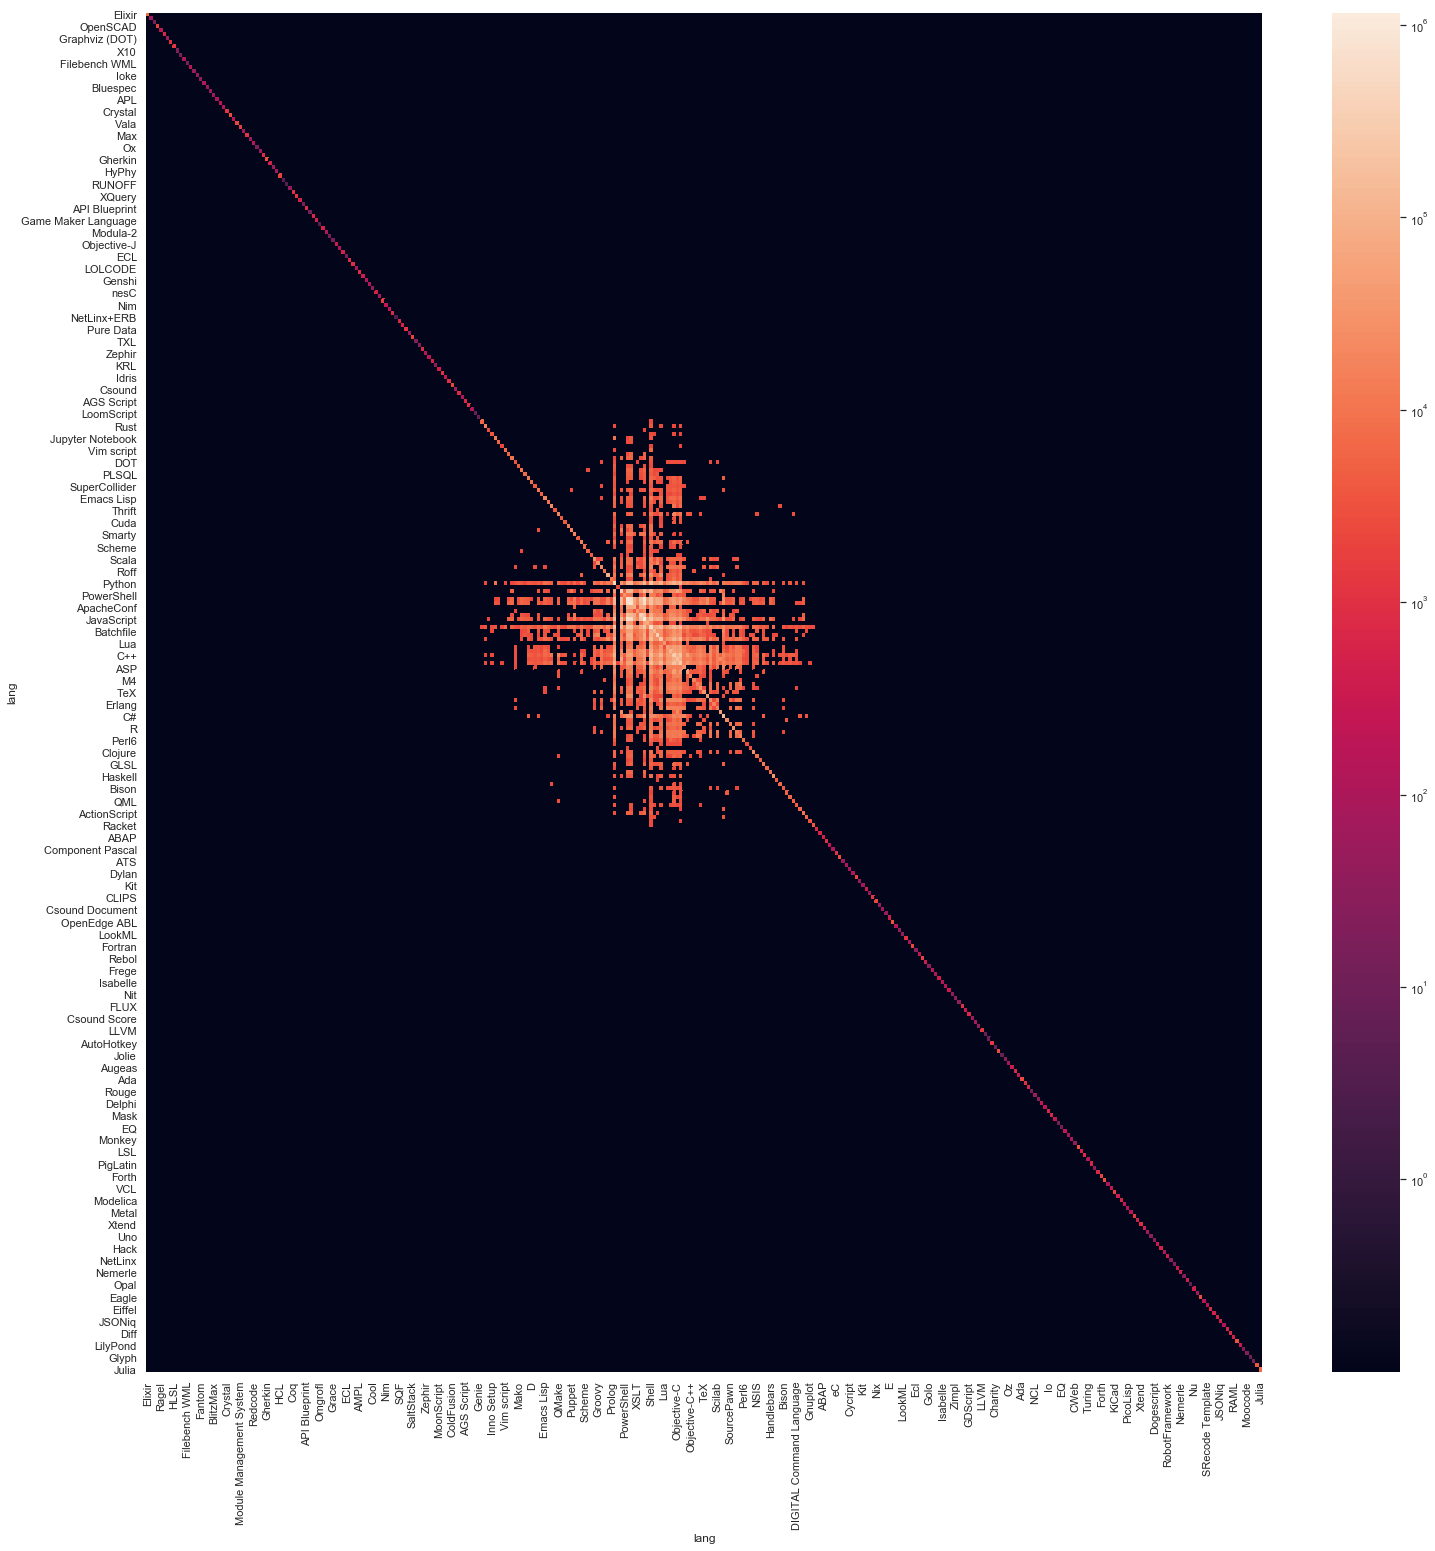

In [11]:
#Calculates Fiedler vector
L = np.diag(np.sum(NoZeroes,1)) - NoZeroes
D, V = np.linalg.eigh(L)

argD = np.argsort(D)

D=D[argD]
V=V[:,argD]
fiedler = V[:,1]
Fperm = np.argsort(fiedler)


#Orders matrix by Fiedler vector
Aperm2 = NoZeroes.iloc[Fperm,:]
Aperm2 = Aperm2.iloc[:,Fperm]


#Creates the heatmap for counts ordered by Fiedler vector elements and with log-scale
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(Aperm2, norm=log_norm, cbar_kws={"ticks": cbar_ticks})

**B.** *2.* Now we will repeat these heatmaps but with the cosine similarity instead.  Note: we will use the same orderings as above.  First, we will order by the same random permutation as in part 1.  

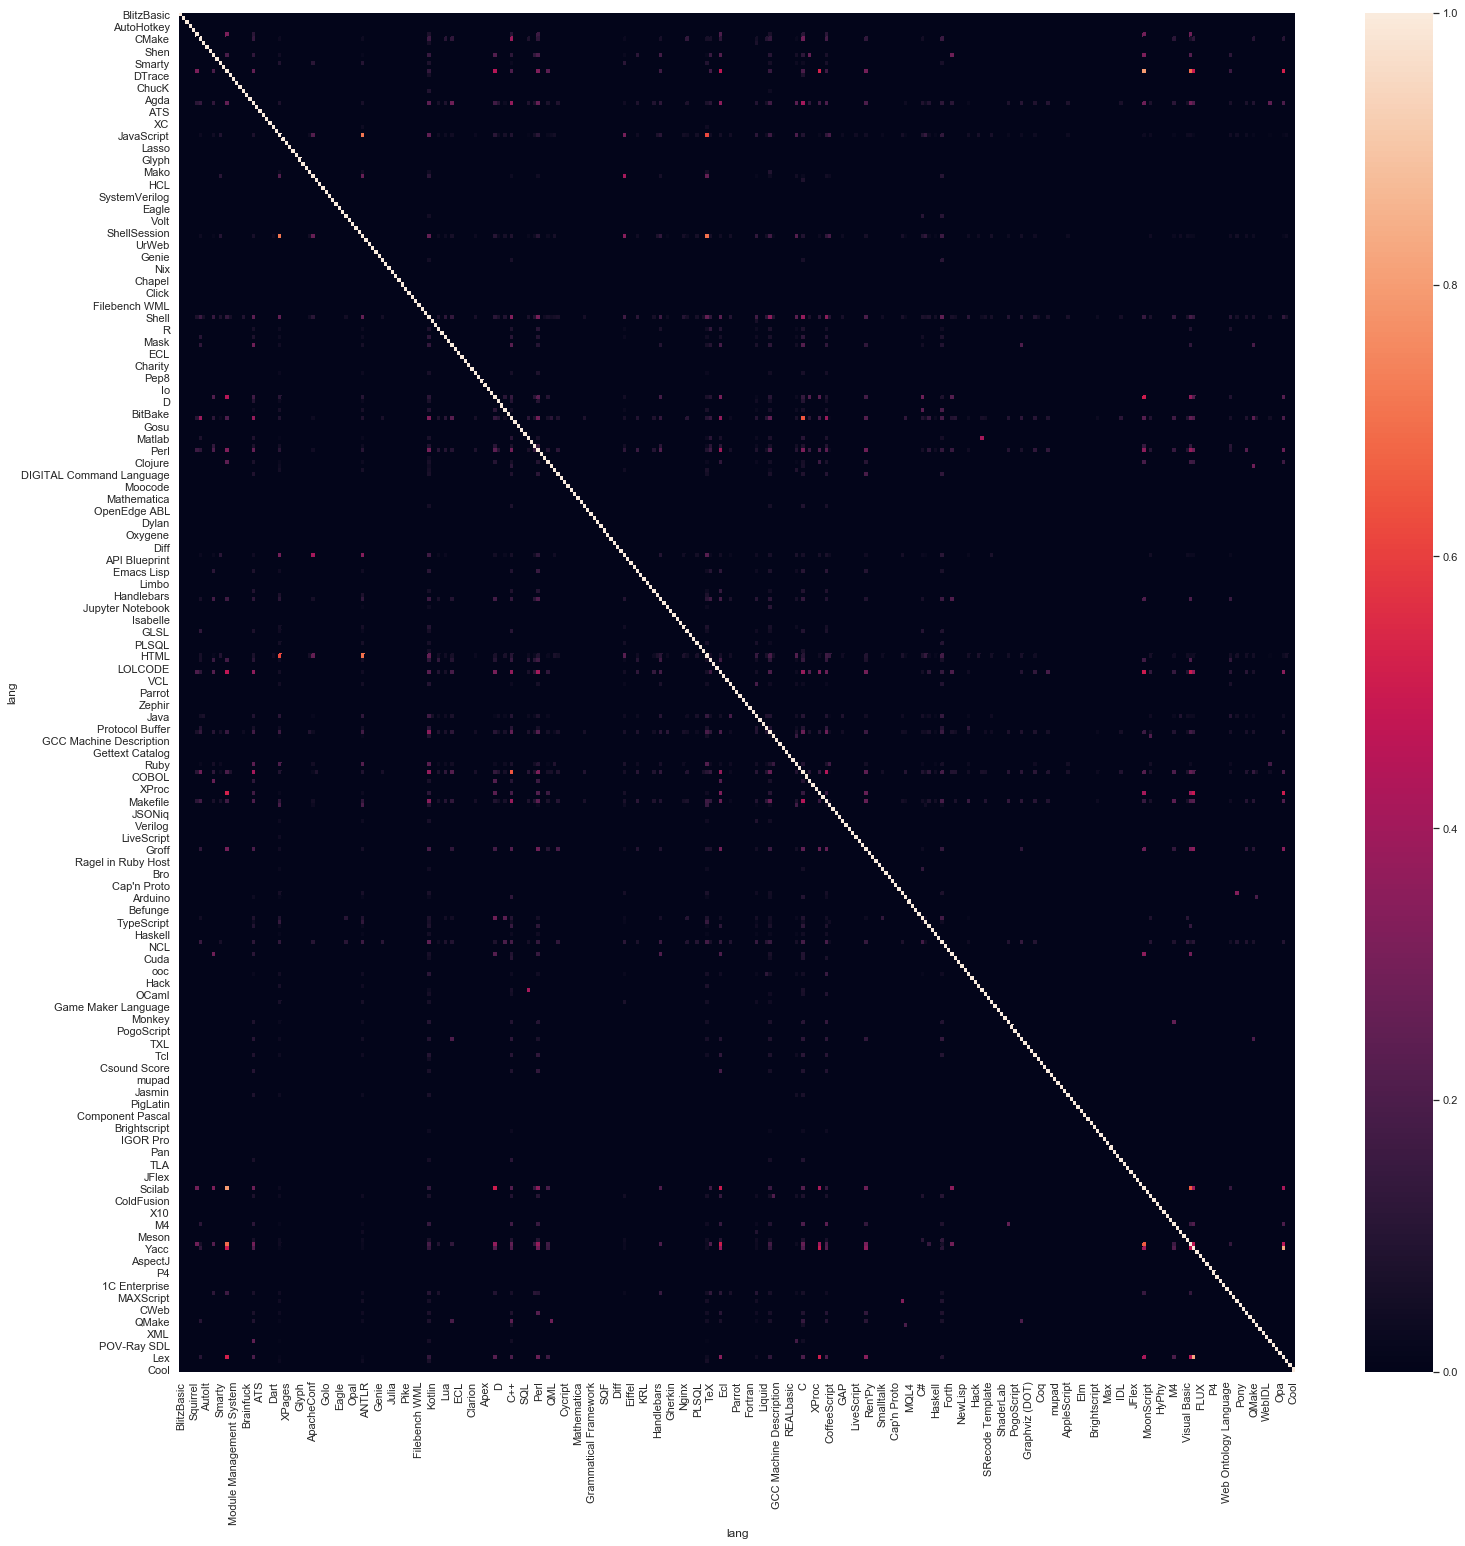

In [12]:
#Orders the matrix by the random permutation
Aperm = CosSim.iloc[rndperm,:] 
Aperm = Aperm.iloc[:,rndperm]


#Creates the heatmap for cosine similarity in random permutation order
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(Aperm)

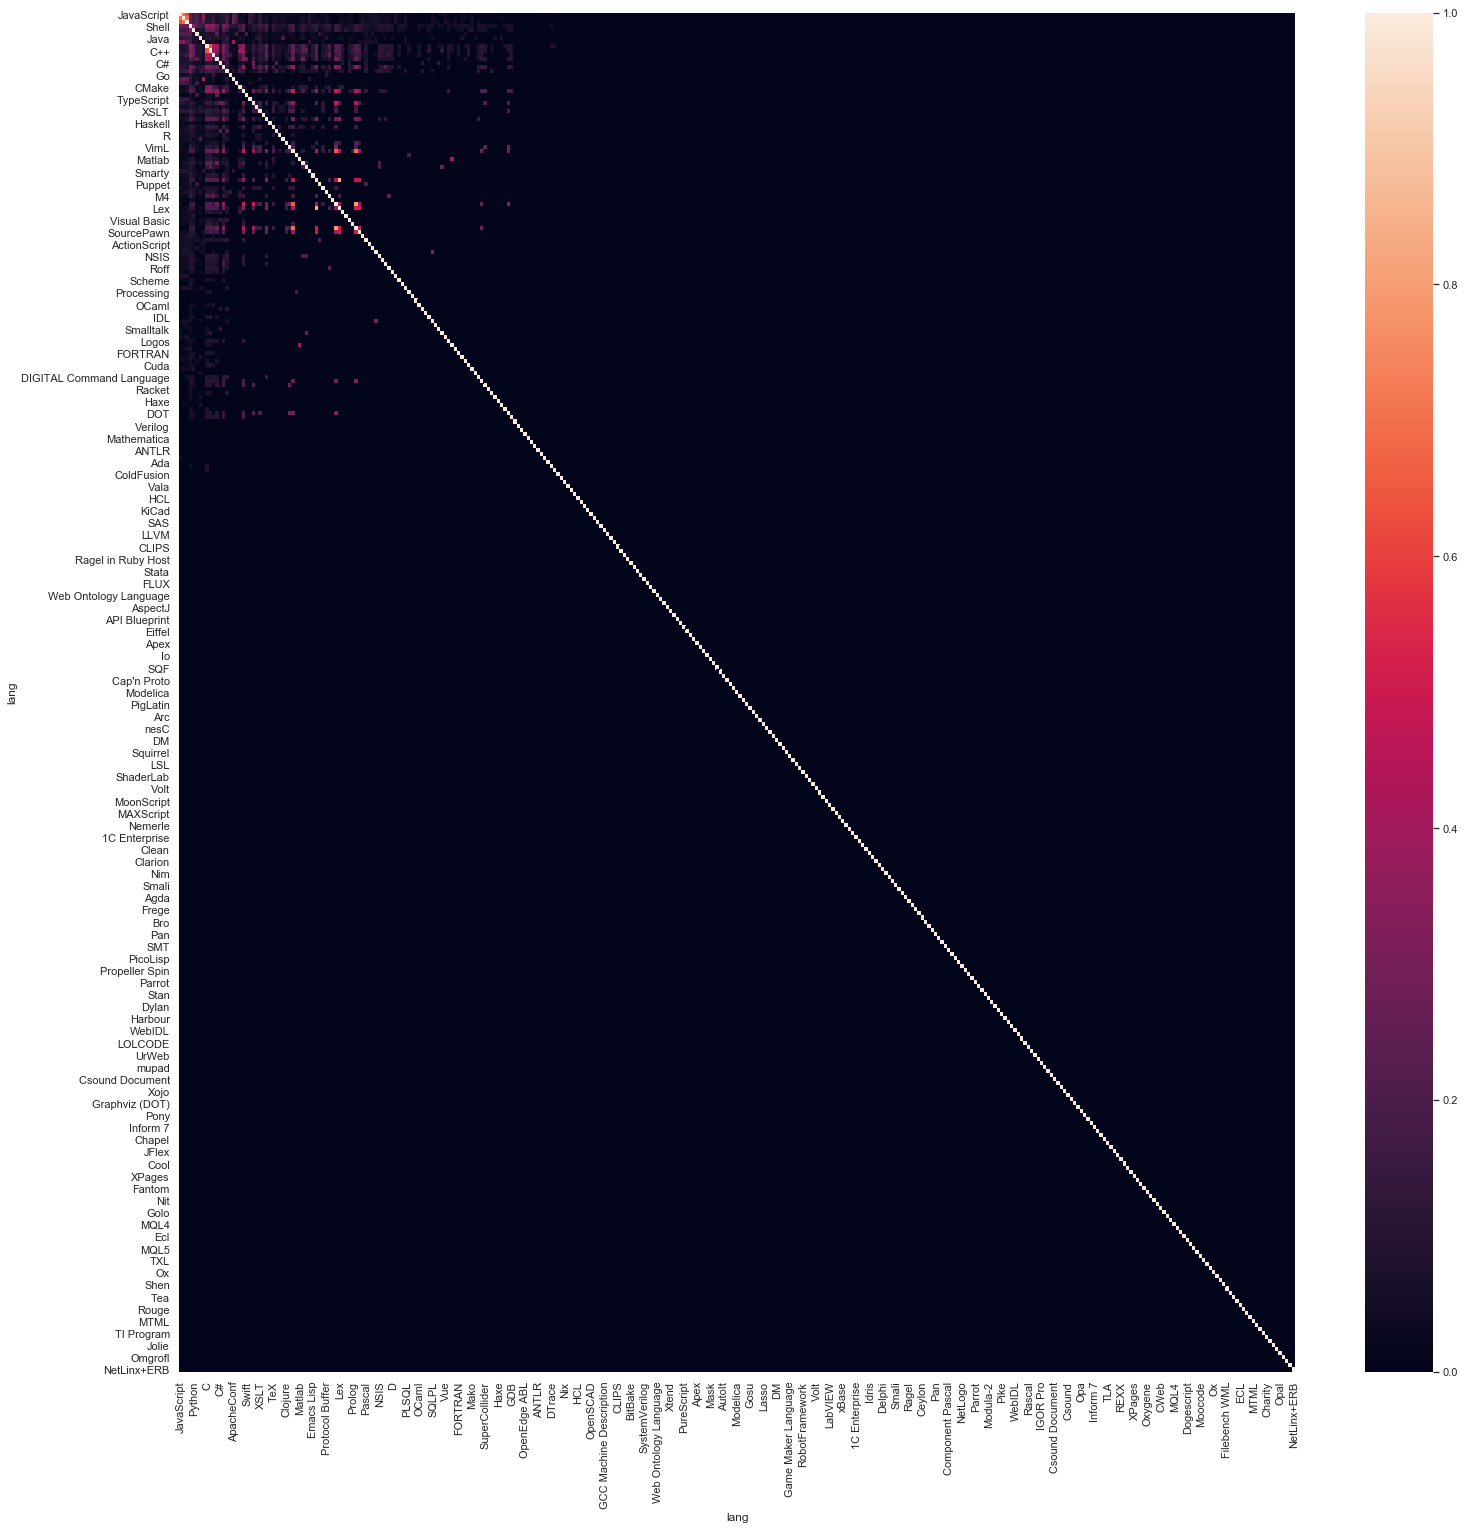

In [13]:
#Creates the heatmap for cosine similarity in decreasing popularity order
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(CosSim)

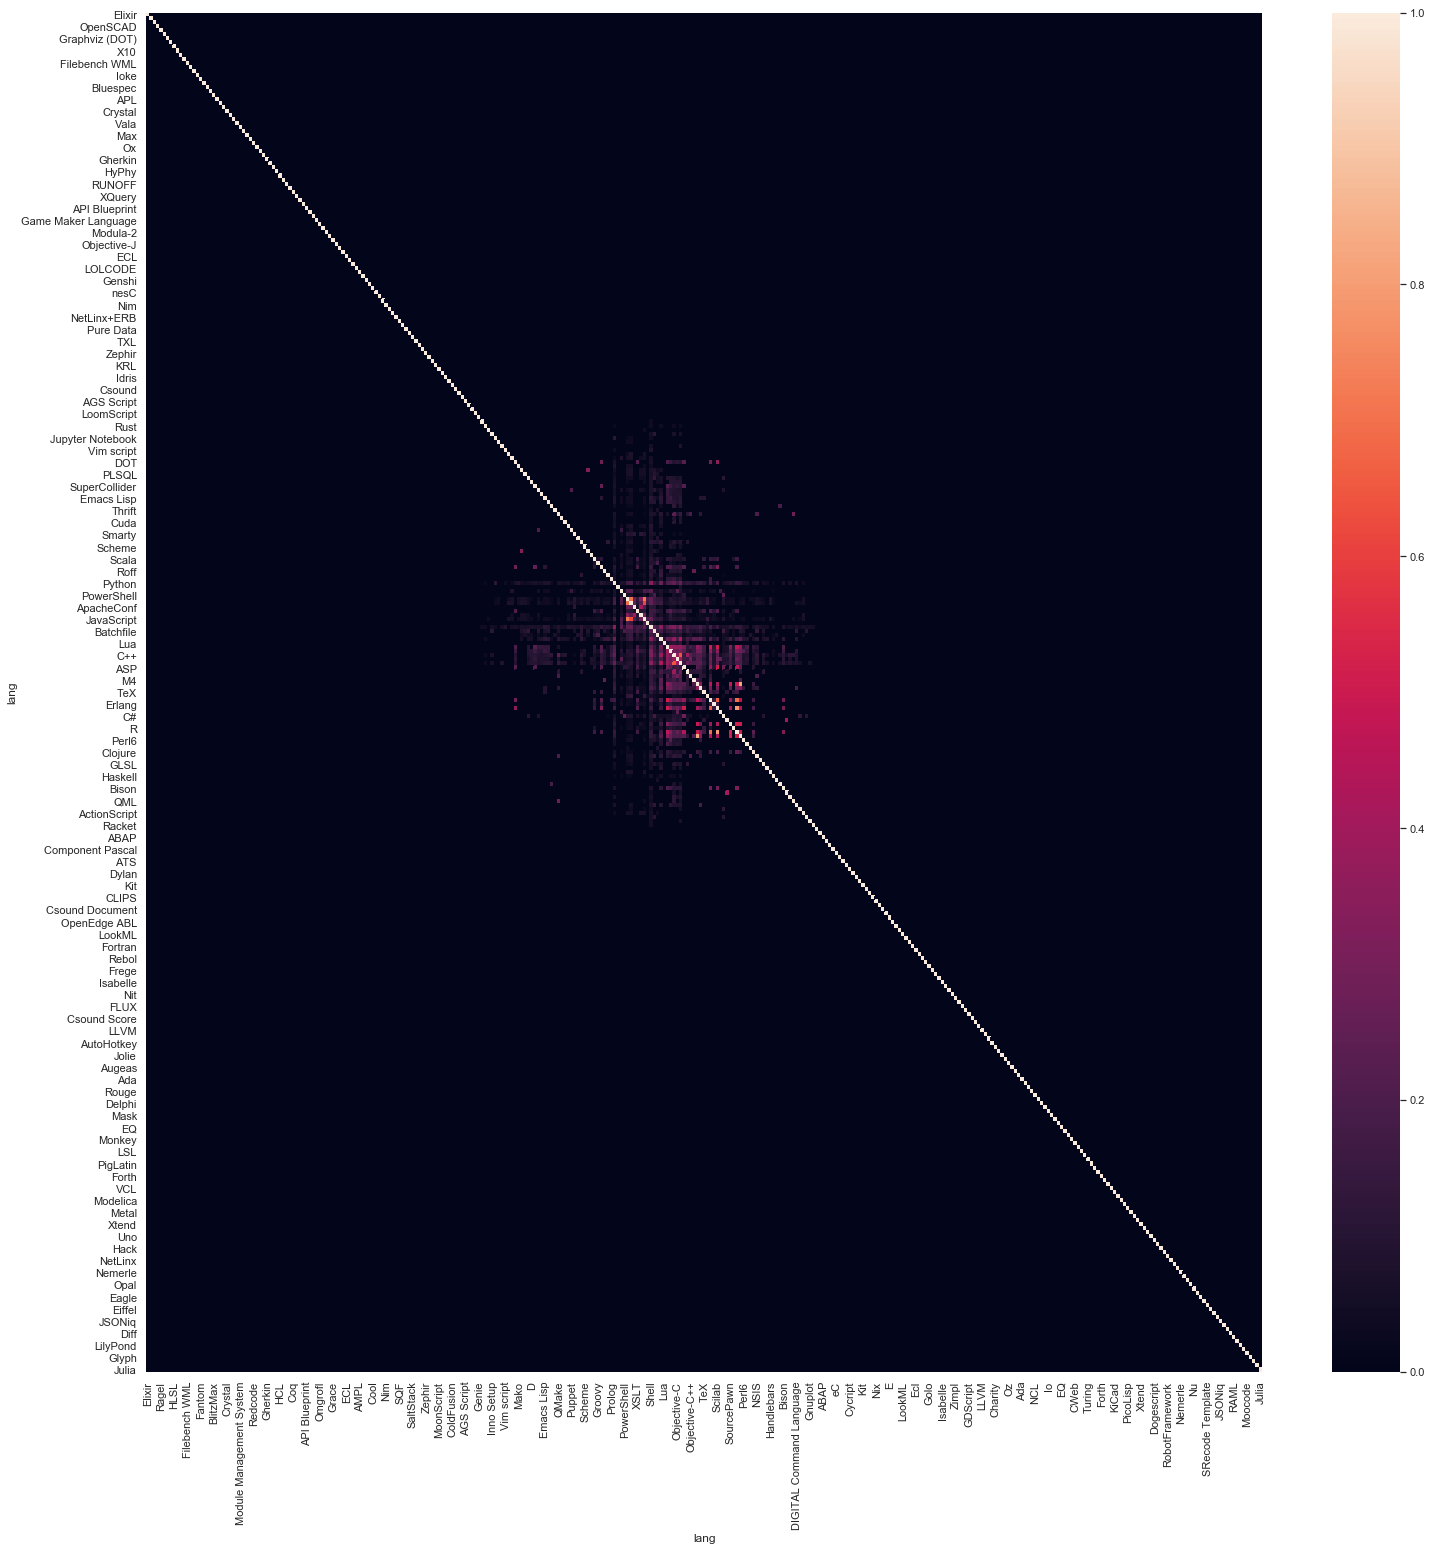

In [14]:
#Orders matrix by Fiedler vector
Aperm2 = CosSim.iloc[Fperm,:]
Aperm2 = Aperm2.iloc[:,Fperm]

#Creates the heatmap for cosine similarity ordered by Fiedler vector elements
plt.rcParams["figure.figsize"] = [25,25]
sns.heatmap(Aperm2)

**C.** *1.* First we will make visualizations of 5 matrices, each with 300 rows and 300 columns and 4 bi-clusters with the following values of the standard deviation of noise: $\sigma$ = 0, 25, 50, 75, and 100.  

Text(0.5,1.05,'Noise = 100')

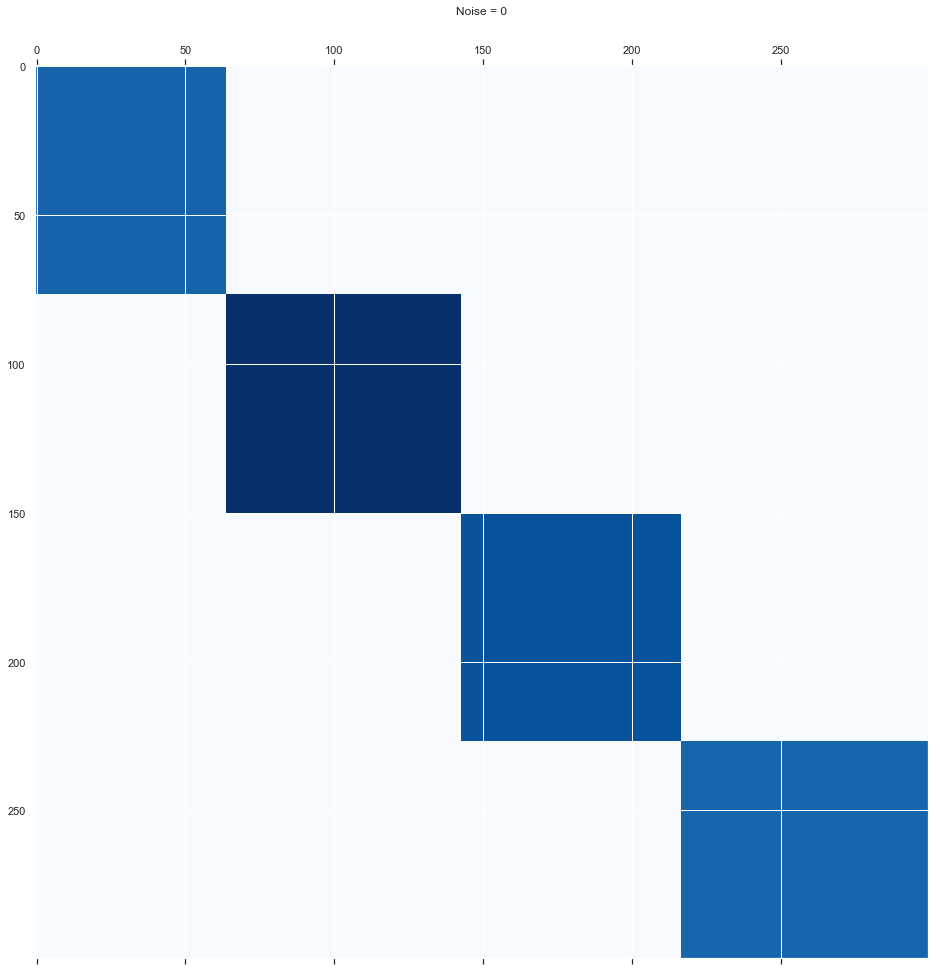

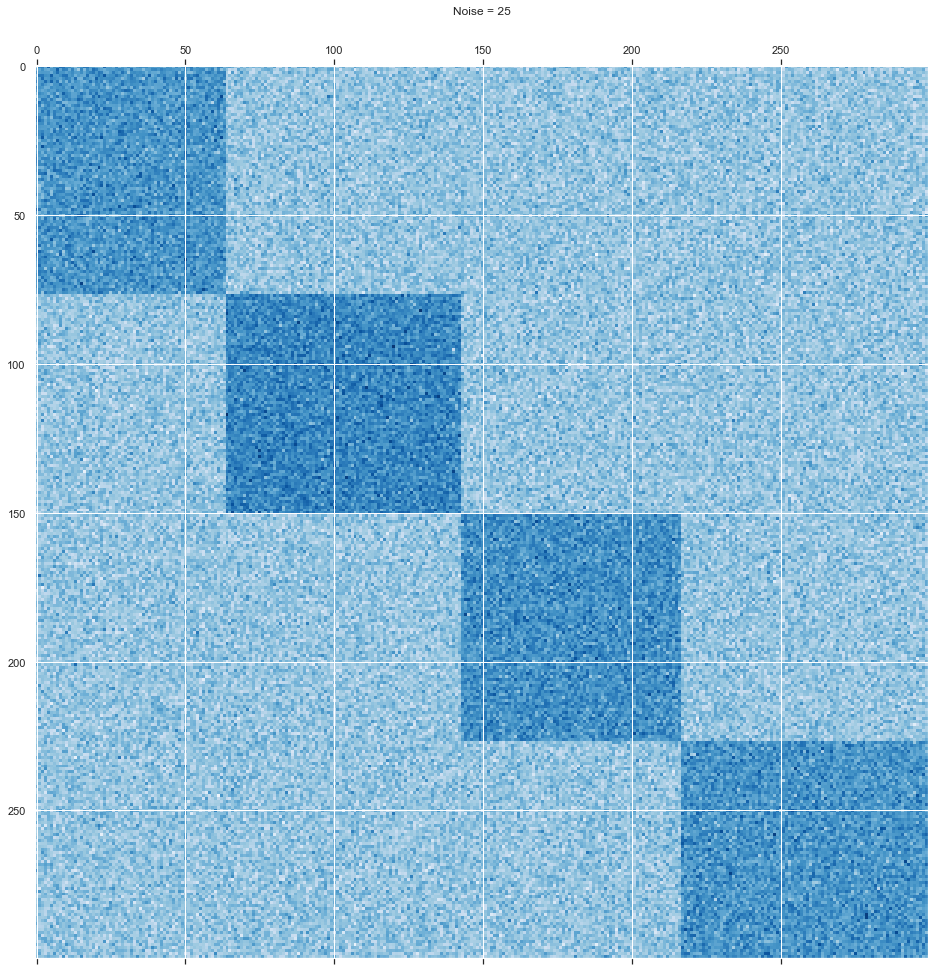

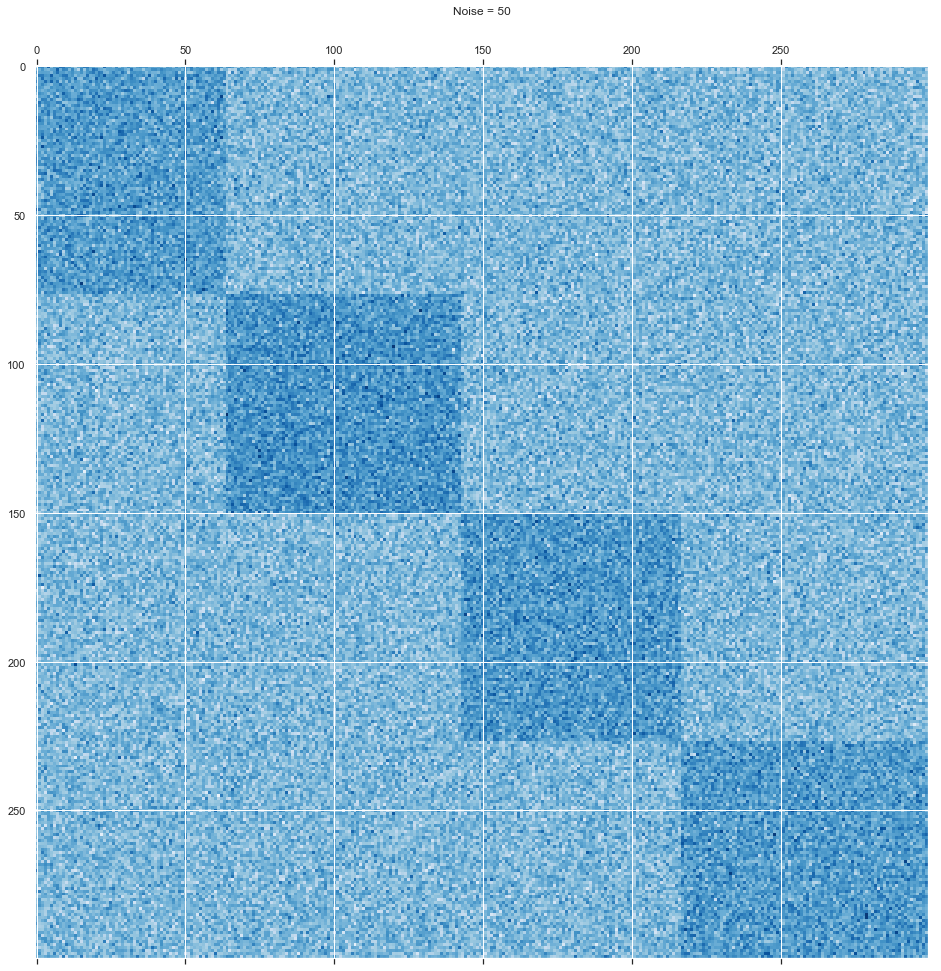

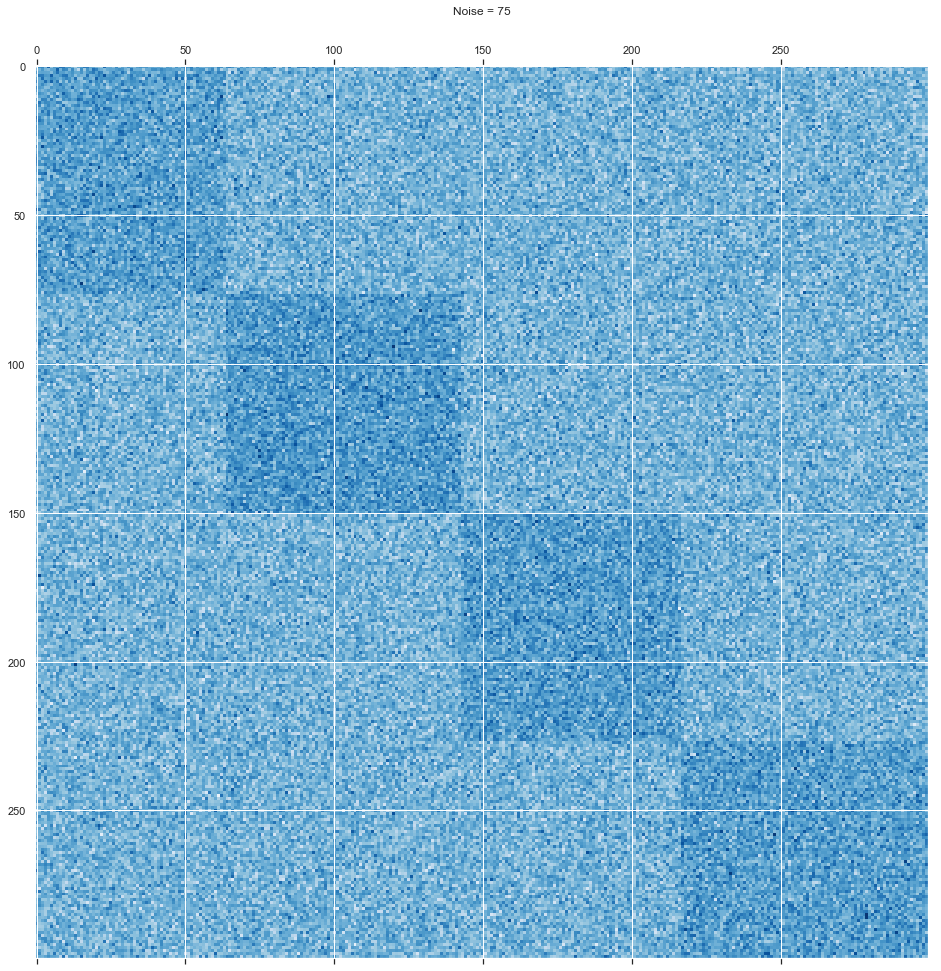

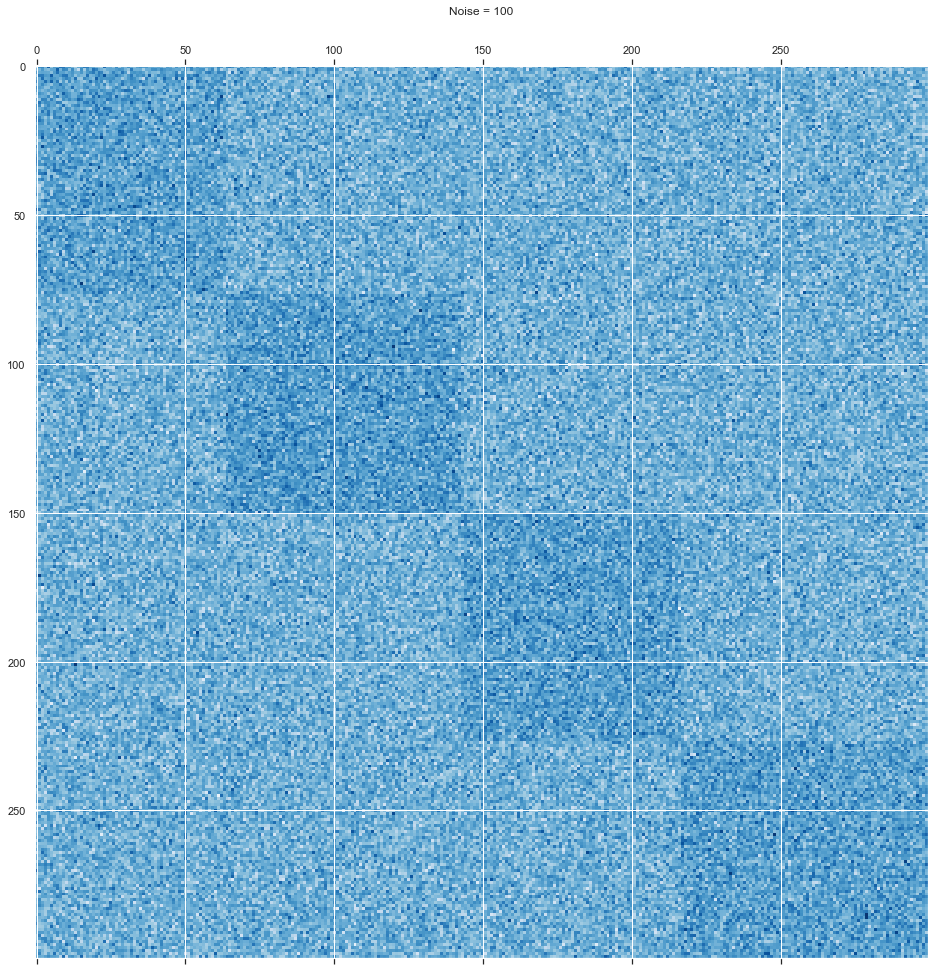

In [15]:
#Visualization for matrix of noise = 0
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=0,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Noise = 0")




#Visualization for matrix of noise = 25
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=25,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Noise = 25")




#Visualization for matrix of noise = 50
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=50,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Noise = 50")



#Visualization for matrix of noise = 75
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=75,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Noise = 75")





#Visualization for matrix of noise = 100
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=100,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Noise = 100")




**C.** *2.* Below, we generate matrices with the same parameters as about but with different noise levels: $\sigma = 0, 5, 10, ..., 95, 100$.  Then we randomly permute the rows and columns and use the spectral co-clustering algorithm to compute the consensus score.  Then we plot this as a function of the noise.  Up through a noise level of around 55, the concensus score stays around 1.  However, after that it starts dropping off and continues to drop off more and more as the noise increases, though even at a noise level of 100, it only drops to just below 0.9.  

Text(0.5,1,'How Noise Effects Consensus Score')

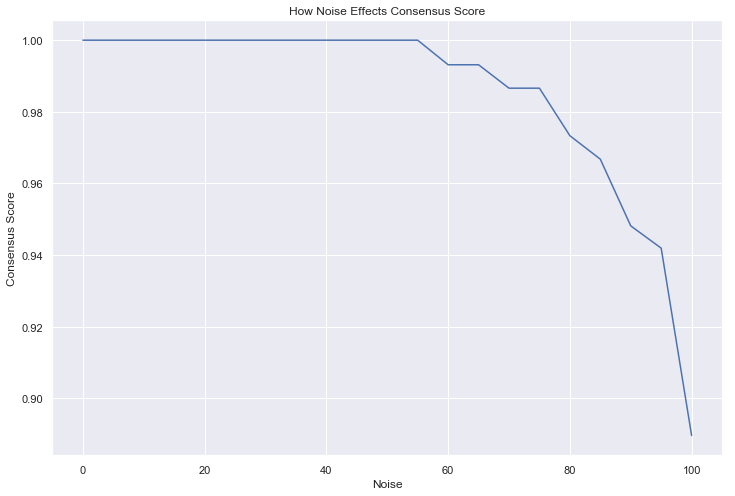

In [16]:
#Creates a blank data frame to store the consensus score in with the noise as the index
ScoreMat = pd.DataFrame(index=range(0, 105, 5), columns=["Score"])
ScoreMat


#Uses a for loop to generate the matrices, permute the rows and columns, and then calculate the consensus score
for i in range(0, 105, 5):
    #Generates the matrix
    data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=4, noise=i,
    shuffle=False, random_state=0)

    #Creates the permutation order for the rows and columns
    data, row_idx, col_idx = sg._shuffle(data, random_state=0)

    #Calculates the consensus score
    model = SpectralCoclustering(n_clusters=4, random_state=0)
    model.fit(data)
    score = consensus_score(model.biclusters_,(rows[:, row_idx], columns[:, col_idx]))
    ScoreMat.loc[i, "Score"] = score


#Plots the consensus score as a function of the noise
plt.rcParams["figure.figsize"] = [12,8]
plt.plot(ScoreMat)
plt.xlabel('Noise')
plt.ylabel('Consensus Score')
plt.title('How Noise Effects Consensus Score')